In [ ]:
#%pip install opencv-python matplotlib pandas ffmpeg-python cv2

In [1]:
import platform
platform.architecture()
import tensorflow as tf

In [2]:

gpu_available = tf.test.is_gpu_available()
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))
print(tf.config.list_physical_devices('GPU'))
print(gpu_available)
print(is_cuda_gpu_available)
print(is_cuda_gpu_min_3)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
True
True


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


GPU Tester code

In [4]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

tf.compat.v1.enable_eager_execution()

# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
learning_rate = 0.1
training_steps = 500
batch_size = 1024
display_step = 100

# Network parameters.
n_hidden_1 = 128 # 1st layer number of neurons.
n_hidden_2 = 256 # 2nd layer number of neurons.

# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# Create TF Model.
class NeuralNet(Model):
    # Set layers.
    def __init__(self):
        super(NeuralNet, self).__init__()
        # First fully-connected hidden layer.
        self.fc1 = layers.Dense(n_hidden_1, activation=tf.nn.relu)
        # First fully-connected hidden layer.
        self.fc2 = layers.Dense(n_hidden_2, activation=tf.nn.relu)
        # Second fully-connecter hidden layer.
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build neural network model.
neural_net = NeuralNet()

# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = neural_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = neural_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x, is_training=True)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

# Test model on validation set.
pred = neural_net(x_test, is_training=False)
print("Test Accuracy: %f" % accuracy(pred, y_test))

step: 100, loss: 0.435450, accuracy: 0.864258
step: 200, loss: 0.302959, accuracy: 0.923828
step: 300, loss: 0.261871, accuracy: 0.922852
step: 400, loss: 0.314974, accuracy: 0.911133
step: 500, loss: 0.237219, accuracy: 0.934570
Test Accuracy: 0.935500


Importing Modules

In [4]:
from __future__ import print_function

import numpy as np
import warnings
import cv2
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K

Extract frames (done)


In [ ]:
'''import cv2
def framer(vid_f,pathout,file):
  count = 0
  vidcap = cv2.VideoCapture(vid_f)
  success,image = vidcap.read()
  while success:
    cv2.imwrite(f"{pathout}/frame{file}_{count}.jpeg", image) # save frame as JPEG file 
    count+=1          
    success,image = vidcap.read()
    print('Read a new frame: ', success)'''

Create Frames (done)

In [ ]:
'''import os
#dataset_path = os.listdir('CricShot10 dataset\\sweep')
#for dataset in dataset_path:
count = 0
dataset="sweep"    
os.makedirs("CricShot10 dataset/" + dataset + '_frames/')
for f in dataset_path:
    count += 1
    framer("CricShot10 dataset/" + dataset + '/' + f, "CricShot10 dataset/" + dataset + '_frames', count)'''

In [9]:
def VGGModel(input_tensor = None, classes = 10): 
    

	input_layer = tf.keras.layers.Input([350,330,3])
	#block1 
	conv1_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3],strides=[1,1], 
		padding='same',activation='relu', name='conv1_1')(input_layer)

	conv1_2 = tf.keras.layers.Conv2D(filters= 64, kernel_size=[3,3], strides= [1,1],
		padding='same',activation='relu', name='conv1_2')(conv1_1)

	pool1_1 = tf.nn.max_pool(conv1_2, ksize = [1,2,2,1],strides=[1,2,2,1],
		padding='SAME', name='pool1_1')


	#block 2
	conv2_1 = tf.keras.layers.Conv2D(filters= 128, kernel_size=[3,3],strides=[1,1],
		padding='same', activation='relu', name='conv2_1')(pool1_1)


	conv2_2 = tf.keras.layers.Conv2D(filters = 128, kernel_size=[3,3], strides = [1,1],
		padding='same', activation='relu', name='conv2_2')(conv2_1)


	pool2_1 = tf.nn.max_pool(conv2_2, ksize = [1,2,2,1], strides= [1,2,2,1],
		padding='SAME', name='pool2_1')



	#block3 

	conv3_1 = tf.keras.layers.Conv2D(filters= 256, kernel_size=[3,3], strides = [1,1],
		padding='same', activation='relu', name='conv3_1')(pool2_1)

	conv3_2 = tf.keras.layers.Conv2D(filters = 256, kernel_size=[3,3], strides=[1,1],
		padding='same', activation='relu', name='conv3_2')(conv3_1)

	conv3_3 = tf.keras.layers.Conv2D(filters = 256, kernel_size= [3,3], strides=[1,1],
		padding='same', activation='relu', name='conv3_3')(conv3_2)

	pool3_1 = tf.nn.max_pool(conv3_3, ksize=[1,2,2,1], strides=[1,2,2,1],
		padding="SAME",name='pool3_1')

	#block4 

	conv4_1 = tf.keras.layers.Conv2D(filters = 512, kernel_size= [3,3], strides=[1,1],
		padding='same', activation='relu', name='conv4_1')(pool3_1)


	conv4_2 = tf.keras.layers.Conv2D(filters = 512, kernel_size= [3,3], strides=[1,1],
		padding='same', activation='relu', name='conv4_2')(conv4_1)


	conv4_3 = tf.keras.layers.Conv2D(filters = 512, kernel_size= [3,3], strides=[1,1],
		padding='same', activation='relu', name='conv4_3')(conv4_2)
	

	pool4_1 = tf.nn.max_pool(conv4_3, ksize=[1,2,2,1],strides=[1,2,2,1],
		padding='SAME', name='pool4_1')

	#block5


	conv5_1 = tf.keras.layers.Conv2D(filters = 512, kernel_size= [3,3], strides=[1,1],
		padding='same', activation='relu', name='conv5_1')(pool4_1)

	conv5_2 = tf.keras.layers.Conv2D(filters = 512, kernel_size= [3,3], strides=[1,1],
		padding='same', activation='relu', name='conv5_2')(conv5_1)

	conv5_3 = tf.keras.layers.Conv2D(filters = 512, kernel_size= [3,3], strides=[1,1],
		padding='same', activation='relu', name='conv5_3')(conv5_2)

	pool5_1 = tf.nn.max_pool(conv5_3, ksize=[1,2,2,1], strides=[1,2,2,1],
		padding='SAME', name='pool5_1')



	flatten  = tf.keras.layers.Flatten()(pool5_1)

	fc6 = tf.keras.layers.Dense(units=4096, name='fc6', activation='relu')(flatten)
	fc7 = tf.keras.layers.Dense(units=4096, name='fc7', activation='relu')(fc6)
	fc8 = tf.keras.layers.Dense(units=1000, name='fc8',activation=None)(fc7)


	prob = tf.nn.softmax(fc8)



	model = tf.keras.Model(input_layer, prob)
 
	return model
	#model.summary()

In [8]:
'''import os,random
path = r'dataset frames\\sweep_frames'# You can provide the path here
n = 2575 # Number of random images to be removed to reach 8,958
img_names = os.listdir(path)  # Get image names in folder
img_names = random.sample(img_names, n)  # Pick 2500 random images
for image in img_names:  # Go over each image name to be deleted
    f = os.path.join(path, image)  # Create valid path to image
    os.remove(f)  # Remove the image'''

In [10]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 
import pickle 
import tensorflow as tf

data_dir = 'dataset frames'

categories = ['cover_frames', 'defense_frames' , 'flick_frames', 'hook_frames', 'late_cut_frames', 'lofted_frames', 'pull_frames', 'square_cut_frames', 'straight_frames', 'sweep_frames']

data = []

In [ ]:
'''for category in categories:
	path = os.path.join(data_dir, category)
	label = categories.index(category)

	for img_name in os.listdir(path):
		image_path = os.path.join(path, img_name)
		#image = cv2.imread(image_path)
		

		try:
			#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
			#image = cv2.resize(image, (240,240))
			#image = np.array(image)

			data.append([image_path, label])

		except Exception as e:
			pass

	print(len(data))
	pik = open('shots.pickle','wb')
	pickle.dump(data, pik)
	pik.close()'''

In [ ]:
'''pick  = open('shots.pickle', 'rb')
data = pickle.load(pick)

pick.close()

#np.random(data)

feature = []
labels = []

for img, label in data:
	feature.append(img)
	labels.append(label)

#feature = np.array(feature, dtype = np.float32)
#feature = feature/ 255.
feature = np.array(feature)
labels = np.array(labels)
'''

In [11]:
batch_size = 4
img_height = 350
img_width = 330

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 84430 files belonging to 10 classes.
Using 67544 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 84430 files belonging to 10 classes.
Using 16886 files for validation.


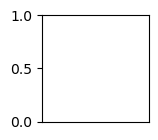

In [14]:
plt.figure(figsize=(8,8))

for i in range(25):
    plt.subplot(5,5,1)
    #plt.imshow(feature[i])
    #plt.xlabel(categories[y_train[i]])
    plt.xticks([])

plt.show()    

In [15]:
'''x_train, x_test, y_train, y_test = train_test_split(feature, labels, test_size=0.1, shuffle=True)

x_train, x_test = tf.cast(x_train, tf.float32), tf.cast(x_test, tf.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size = 10)
'''
 

model = VGGModel(classes = 10)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adadelta()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [16]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [17]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=2
)

Epoch 1/2


c:\Users\UMER\.conda\envs\fyp\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16886/16886 [==============================] - 4773s 282ms/step - loss: 7.7888 - accuracy: 0.1057 - val_loss: 2.2840 - val_accuracy: 0.1086
Epoch 2/2
16886/16886 [==============================] - 4635s 274ms/step - loss: 2.2836 - accuracy: 0.1043 - val_loss: 2.2821 - val_accuracy: 0.0997


In [ ]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training = True)
        loss = loss_object(y_true=labels, y_pred=predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, model.trainable_variable))
    
    train_loss(loss)
    train_accuracy(labels, predictions)
    
    
for epoch in range(5):
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    step = 0
    
    for images, labels in train_dataset:
        step+=1 
        train_step(images, labels)
        
        if step%10==0:
            
            print('=> epoch: %i, loss: %.4f, train_accuracy: $.4f'%(epoch+1, train_loss.result(), train_accuracy.result()))
        
        

In [ ]:
prediction = model(x_test[0:9])

plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[i])
    plt.xlabel('Predicted: %s\n Actual: %s'%(categories[np.argmax(prediction[i])], categories[y_test[i]]))
    
    plt.xticks([])
    
plt.show() 

Custom VGG16 model

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_path = os.listdir('dataset frames')

shot_types = os.listdir('dataset frames')
print (shot_types)

print("Types of shots: ", len(dataset_path))

In [ ]:
shots = []

for item in shot_types:
    # Getting all the file names
    all_shots = os.listdir('dataset frames' + '/' +item)


    for shot in all_shots:
        shots.append((item, str('dataset frames' + '/' +item) + '/' + shot))
        #print(shots)'''

In [ ]:
# building a dafaframe
shots_df = pd.DataFrame(data=shots, columns=['Shot Type', 'Image'])
print(shots_df.head)
print(shots_df.columns)

In [ ]:
# Cheking how many images are present for each shot
print("Total number shot images in dataset: ", len(shots_df))

shot_count = shots_df['Shot Type'].value_counts()

print("Number of different shots: ")
print(shot_count)

In [ ]:
'''import numpy as np
import cv2

%matplotlib inline
from matplotlib import pyplot as plt
d=100
x=460
h=350
w=330
img = cv2.imread("dataset frames\\cover_frames\\frame1_0.jpeg")
#plt.imshow(img)
#crop_img = img[d:d+h, x:x+w]
#cv2.imshow("cropped", crop_img)
plt.imshow(img)'''


In [ ]:

path = 'dataset frames/'

#im_size = 180
d=100
x=460
h=350
w=330
#images = np.array([])
#labels = []
count=0
#for i in shot_types:
data_path = path + str("sweep_frames")
filenames = [i for i in os.listdir(data_path)]

for f in filenames:
    print(f)
    img = cv2.imread(data_path + '/' + f)
    #plt.imshow(img)
    #print(img.shape)
    if(img.shape[0]<=350): continue
    cimg = img[100:100+350, 460:460+330]
    
    cv2.imwrite(data_path + '/' + f,cimg)
    #images = np.append(images,[img])
    #labels.append(i)
    count=count+1
    #print(len(images),count)


        
        
#np.save("csv",images)'''

In [ ]:
lower_white = np.array([0,0,168])
lower_brown = np.array([10,100,20])

In [ ]:
for category in categories:
	path = os.path.join(data_dir, category)

    for img_name in os.listdir(path):
        image_path = os.path.join(path, img_name)
        cv2.imread(image_path)
        #cv2.imshow("Original frame", image_path)
        hsv = cv2.cvtColor(image_path,cv2.COLOR_BGR2HSV)

        mask = cv2.inRange(hsv, lower_white, lower_brown)
        #cv2.imshow("Masked frame", mask)


In [ ]:
'''#np.save("csv",images)
#images = np.array(images)
print(images)'''


In [ ]:
'''from sklearn.preprocessing import LabelEncoder , OneHotEncoder
y = shots_df['Shot Type'].values

y_labelencoder = LabelEncoder()
y = y_labelencoder.fit_transform(y)
print(y)
#y.shape()'''

In [ ]:
#y = y.reshape(1,-1)
#onehotencoder = OneHotEncoder(categorical_features=[0])
#Y = onehotencoder.fit_transform(y)
#P = ColumnTransformer([("Shot", OneHotEncoder(), [0])])
#Y = P.fit_transform(y)
#print(len(images))
#Y.shape

In [ ]:
'''#images=np.load("csv.npy")
images = images.astype('float32') / 255.0
image, y = shuffle(images, y, random_state=1)

train_x, test_x, train_y, test_y = train_test_split(images, y, test_size=0.175, random_state=415)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)'''

In [ ]:
'''model.fit(train_x, train_y, epochs = 50, batch_size = 10)'''

In [ ]:
'''preds = model.evaluate(test_x, test_y)
print("Loss = " + str(preds[0]))
#print("Test Acuuracy = " + str(preds[1]))'''